# Gridworld with First Visit

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import uniform
import random
from IPython.display import display, clear_output

In [2]:
actions = [[-1, 0], [0, 1], [1, 0], [0, -1]] #up, right, down, left = (clockwise from up) 
action_count = len(actions) # total number of actions
gridSize = 5 # create a square grid of gridSize by gridSize
state_count = gridSize*gridSize # total number of states

In [3]:
class Gridworld():
    def __init__(self, gridSize):
        self.valueMap = np.zeros((gridSize, gridSize))
        self.states = [[i, j] for i in range(gridSize) for j in range(gridSize)]
        self.size = gridSize
        self.new_pos = [0, 0] # initialize new position for p_transition
        self.transition_prob = 1 # deterministic
    
    def initial_state(self):        # return initial state
        return grid.states[gridSize*gridSize-1]
   
    def transition_reward(self, current_pos, action): # return the transition probability

        # get next position: state: [0, 0], action: [0, 1], new_state = [0, 1]
        self.new_pos = np.array(current_pos) + np.array(action)

        # normally, reward = 0
        reward = 0

        # if new pos results in off the grid, return reward -1
        if -1 in self.new_pos or self.size in self.new_pos:
            reward = -1
        # if in state A, receive + 10
        if current_pos == [0, 1]:
            reward = 10
        # if in state B, receive + 5
        if current_pos == [0, 3]:
            reward = 5

        # if taking an action crosses the border; agent's new_pos is the same as the current pos
        if -1 in self.new_pos or self.size in self.new_pos: 
            self.new_pos = current_pos
            
        # if in state A, transition to state A'
        if current_pos == [0, 1]:
            self.new_pos = [4, 1]
            
        # if in state B, transition to state B'
        if current_pos == [0, 3]:
            self.new_pos = [2, 3]

        return self.new_pos, reward

## Define Functions

In [4]:
def generate_episode(steps, policy): #Modification: added policy to the function 

    # set initial state
    state_vector = grid.initial_state()

    # initialize state (with iniitial state), action list and reward list
    state_list = [state_vector]
    action_list = []
    reward_list = []

    # generate an episode
    for i in range(steps):

        # pick an action based on categorical distribution in policy
        action_index = int(np.random.choice(action_count, 1, p=policy[grid.states.index(state_vector)])) 
        
        action_vector = actions[action_index] # convert the integer index (ie. 0) to action (ie. [-1, 0])

        # get new state and reward after taking action from current state
        new_state_vector, reward = grid.transition_reward(state_vector, action_vector)
        state_vector = list(new_state_vector) 
        # save state, action chosen and reward to list
        state_list.append(state_vector)
        action_list.append(action_vector)
        reward_list.append(reward)
       
    return state_list, action_list, reward_list

In [5]:
# define average function
def Average(lst): 
    return sum(lst) / len(lst) 

## First Visit MC

In [6]:
# create a grid object
grid = Gridworld(5)

# initialize q values for all state action pairs
Q_values = np.zeros((state_count, action_count))

# intialize parameters
gamma = 0.99
eps = 0.1

# iterate 500 times: each time, generating an episode of 200 steps
max_steps = 200
# Define lists for plots
average_reward_list = []
cumulative_reward_list = []
cumulative_reward = 0
delta_list = []
episode_test_reward_list = []

In [7]:
# Initiate a random policy
random_policy = np.random.randint(100, size=(state_count, action_count))
random_policy = random_policy/random_policy.sum(axis=1)[:,None]
policy = random_policy


In [8]:
# define variables for keeping track of time steps
Terminal = max_steps
t_list=[]
for i in range(1,max_steps+1):
    t = Terminal - i
    t_list.append(t)

In [9]:
episode_length = 500

#Modification: added a dictionary of state and list of returns received
returns_list = {}
for s in range(state_count):
    for a in range(action_count):
        returns_list[(s,a)] = []

# iteration 500 times

for episode in range(episode_length):
  
    # generate an episode of specified step count
    #print("probability", policy[grid.states.index(state_vector)])
    state_list, action_list, reward_list = generate_episode(max_steps, policy)
    #print("probabilidad", policy[grid.states.index(state_vector)])
    # calculate average reward of each episode
    average_reward_list.append(Average(reward_list))
    
    # obtain cumulative reward for plotting
    cumulative_reward = cumulative_reward + sum(reward_list)
    cumulative_reward_list.append(cumulative_reward)

    # intialize variables
    G = 0
    delta = 0
    
    # initiate visited list to none
    visited_list = []

    # loop for each step of episode: T-1, T-2, T-3 ... 0 = 199, 198, 197 ... 0
    for t in t_list:

        # calculate G: starting with the last reward at index t (naturally accounts for pseudocode's "t-1")
        G = gamma*G + reward_list[t]
        
        # combine state action pair, for example, state = [0,0], action = [0,1], state_action_pair = [0,0,0,1]
        state_action_pair = []
        state_action_pair.extend(state_list[t])
        state_action_pair.extend(action_list[t])

        # check if state action pair have been visited before (if not: continue, else: move to the next time step)
        if state_action_pair not in visited_list:

            # add state action pair to visited list
            visited_list.append(state_action_pair)
            
            # find state and action index, for example, converting action [-1, 0] to 0, and same for state #
            state_index = grid.states.index(state_list[t])
            action_index = actions.index(action_list[t])

            # append G to returns
            returns_list[(state_index,action_index)].append(G)

            # calculate max delta change for plotting max q value change
            delta = max(delta, np.abs(Average(returns_list[(state_index,action_index)]) - Q_values[state_index][action_index]))      
            
            # write Q_values to the state-action pair
            Q_values[state_index][action_index] = Average(returns_list[(state_index,action_index)])
    
    #MODIFICATION: adjusted updating rule    
    for s in range(state_count):
        if np.count_nonzero(Q_values[s]) == 0:  # if Q_values is all zero, randomly pick an action
            choose_action = random.randint(0,3)
        else:
            choose_action = np.argmax(Q_values[s]) # choose best action at given state
        # overwrite policy
        for a in range(action_count): # for action in actions [0, 1, 2, 3]
            if choose_action == a: # if the choose_action is the same as the current action
                policy[s][a] = 1 - eps
            else: # if choose_action is not the same as the current action 
                policy[s][a] = eps/(action_count-1)
    

    # append delta to list
    delta_list.append(delta)
    
    # TEST POLICY after each episode
    # Generate test trajectory with the greedy policy
    state_list, action_list, test_reward_list = generate_episode(200, policy)
    
    # sum up all the rewards obtained during test trajectory and append to list
    episode_test_reward_list.append(sum(test_reward_list))
    
    # print current episode
    clear_output(wait=True)
    display('Episode: ' + str(episode))


'Episode: 499'

In [17]:
returns_list

{(0, 0): [10.517543550620438,
  -1.0,
  -3.9109950099999997,
  -1.0,
  -1.9607231258574767,
  -8.867471635634447,
  -28.815471839004996,
  -1.0,
  12.319407111097004,
  5.884154416695441,
  -3.0831228905124366],
 (0, 1): [0.5284871716129275,
  -11.81206673280493,
  -7.9469410460954,
  13.453946576865661,
  -9.111289330905032,
  6.9536913299953955,
  3.4489368816356842,
  -10.335695528931245,
  -2.1041645358711483,
  9.9,
  4.16446944279201,
  23.915508660415508,
  13.20390168872151],
 (0, 2): [11.63388237436408,
  0.5179702768978303,
  -20.22786406008532,
  -2.9403989999999998,
  0.0,
  -0.970427399856037,
  -28.09643620101515,
  -51.722473397151525,
  6.111172395328652],
 (0, 3): [-3.9403989999999998, -26.02996266117195],
 (1, 0): [2.3517247483640897,
  -0.3615128283870721,
  2.3517247483640897,
  9.122478977001032,
  6.09900499,
  1.3430154691272076,
  -2.822463874384912,
  70.36202204381573,
  10.0,
  10.0,
  0.6120388770448653,
  10.0,
  -7.856848509659603,
  6.09900499,
  14.79184

In [18]:
Q_values

array([[ -1.9015,   2.6353,  -9.5216, -14.9852],
       [  7.0377,   7.5634,   0.0889,   6.724 ],
       [  5.8752,   6.471 ,   6.1893,   5.8764],
       [ 10.4767,  10.0758,  10.4584,  11.2136],
       [  6.319 ,   1.6155,  -0.677 ,   7.1173],
       [ -4.8439,   5.3966,  -1.5513,   1.4608],
       [  5.1191,   5.8353,   5.6151,   1.3527],
       [  5.0056,   5.2393,   2.6433,   4.5522],
       [  4.76  ,   4.8483,   4.233 ,   4.5369],
       [  3.4745,   2.4249,   2.5557,   4.6812],
       [  4.1277,   4.4089,  -2.0134,  -0.065 ],
       [  4.3266,   3.7368,   1.8918,   4.3225],
       [  2.7732,   3.2373,   1.4565,   2.2926],
       [  2.5149,   2.5865,   2.4808,   2.577 ],
       [  2.477 ,   1.0788,   1.8387,   2.9615],
       [  3.1611,  -1.5018,  -9.6527,   2.8792],
       [  3.0746,   2.9855,  -3.5904,  -1.9424],
       [  2.7319,   2.8484,  -0.0793,   2.9187],
       [  3.3947,   2.3937,   2.348 ,   2.1392],
       [  1.5719,   1.3323,  -1.1203,   1.977 ],
       [ -4.0875,  -

## Plots 

In [10]:
window_length = int(episode_length/20)

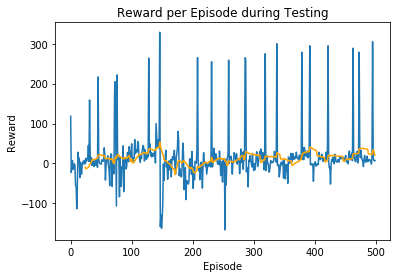

In [11]:
# test reward of each episode
plt.plot(episode_test_reward_list)
plt.title('Reward per Episode during Testing')
plt.xlabel('Episode')
plt.ylabel('Reward')

# plot moving average
delta_frame = pd.DataFrame(episode_test_reward_list)
rolling_mean = delta_frame.rolling(window=window_length).mean()
plt.plot(rolling_mean, label='Moving Average', color='orange')

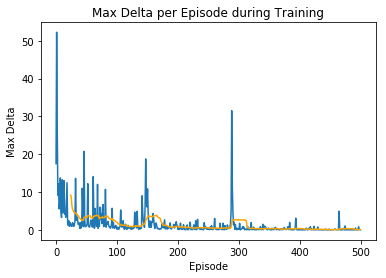

In [12]:
# max delta of each episode, where delta is the change in Q values
plt.plot(delta_list)
plt.title('Max Delta per Episode during Training')
plt.xlabel('Episode')
plt.ylabel('Max Delta')

# plot moving average
delta_frame = pd.DataFrame(delta_list)
rolling_mean = delta_frame.rolling(window=window_length).mean()
plt.plot(rolling_mean, label='Moving Average', color='orange')

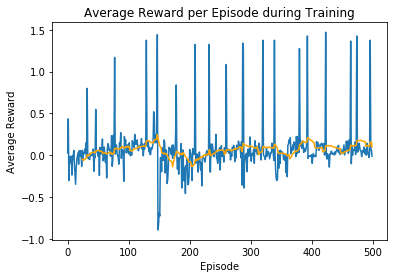

In [13]:
# average reward per episode
plt.plot(average_reward_list)
plt.title('Average Reward per Episode during Training')
plt.xlabel('Episode')
plt.ylabel('Average Reward')

# plot moving average
reward_frame = pd.DataFrame(average_reward_list)
rolling_mean = reward_frame.rolling(window=window_length).mean()
plt.plot(rolling_mean, label='Moving Average', color='orange')

Text(0, 0.5, 'Cumulative Reward')

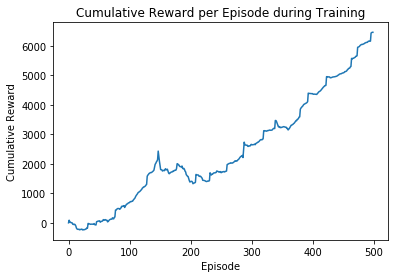

In [14]:
# cumulative reward per episode
plt.plot(cumulative_reward_list)
plt.title('Cumulative Reward per Episode during Training')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')

In [15]:
np.set_printoptions(precision=4)
Q_values

array([[ -1.9015,   2.6353,  -9.5216, -14.9852],
       [  7.0377,   7.5634,   0.0889,   6.724 ],
       [  5.8752,   6.471 ,   6.1893,   5.8764],
       [ 10.4767,  10.0758,  10.4584,  11.2136],
       [  6.319 ,   1.6155,  -0.677 ,   7.1173],
       [ -4.8439,   5.3966,  -1.5513,   1.4608],
       [  5.1191,   5.8353,   5.6151,   1.3527],
       [  5.0056,   5.2393,   2.6433,   4.5522],
       [  4.76  ,   4.8483,   4.233 ,   4.5369],
       [  3.4745,   2.4249,   2.5557,   4.6812],
       [  4.1277,   4.4089,  -2.0134,  -0.065 ],
       [  4.3266,   3.7368,   1.8918,   4.3225],
       [  2.7732,   3.2373,   1.4565,   2.2926],
       [  2.5149,   2.5865,   2.4808,   2.577 ],
       [  2.477 ,   1.0788,   1.8387,   2.9615],
       [  3.1611,  -1.5018,  -9.6527,   2.8792],
       [  3.0746,   2.9855,  -3.5904,  -1.9424],
       [  2.7319,   2.8484,  -0.0793,   2.9187],
       [  3.3947,   2.3937,   2.348 ,   2.1392],
       [  1.5719,   1.3323,  -1.1203,   1.977 ],
       [ -4.0875,  -

## Visualize Final Policy

In [16]:
# PRINT POLICY TABLE ################################################################################
# import pandas library
import pandas as pd
# define column and index
columns=range(grid.size)
index = range(grid.size)
# define dataframe to represent policy table
policy_table = pd.DataFrame(index = index, columns=columns)

# iterate through policy to make a table that represents action number
# as action name (eg. left, right, up, down)
for state in range(len(policy)):
    
    # find the best action at each state
    best_action = np.argmax(policy[state])

    # get action name
    if best_action == 0:
        action_name = 'up'
    elif best_action == 1:
        action_name = 'right'
    elif best_action == 2:
        action_name = 'down'
    else:
        action_name = 'left'

    # calculate the row and column coordinate of the current state number
    row = int(state/grid.size)
    column = round((state/grid.size - int(state/grid.size))*grid.size)
            
    # assign action name
    policy_table.loc[row][column] = action_name

print("Policy Table: ")
print(policy_table)
print()

Policy Table: 
       0      1      2      3     4
0  right  right  right   left  left
1  right  right  right  right  left
2  right     up  right  right  left
3     up     up   left     up  left
4   down     up     up     up  left

